# KITTI 3D Object Detection Evaluation 2017: Data Exploration
## William Darling

The Kitti 3D Object Detection Evaluation 2017 [1] is a dataset and evaluation framework focusing on computer vision algorithms for object detection and 3D orientation prediction. The data consists of 7481 training images and 7519 test images (along with corresponding point clouds) and in total amounts to 80,256 labeled objects. The data can be downloaded from the [KITTI website](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d).

### Initial Data Exploration

Before looking into various techniques for 3D object detection, let's get a feel for the make-up of the dataset. First, we can compile some statistics on the distribution of the training set (we assume the test set has a similar distribution but the labels are hidden so our initial investigation focuses only on the former set).

What does a label file look like?

In [1]:
import os

basedir = 'data/full_training'
example_label_file = os.path.join(basedir, 'label_2', '007480.txt')
open(example_label_file).readlines()

['Car 0.60 3 -2.42 0.00 185.93 214.05 348.86 1.56 1.57 4.37 -6.96 1.73 7.83 -3.13\n',
 'Car 0.00 1 -2.73 57.68 178.66 341.72 285.91 1.65 1.68 3.88 -6.88 1.77 12.36 3.05\n',
 'Car 0.00 2 0.40 133.20 154.23 386.37 263.44 2.08 1.80 4.37 -7.14 1.75 14.97 -0.04\n',
 'Cyclist 0.00 0 1.66 501.01 178.40 523.53 228.03 1.59 0.58 1.69 -3.29 1.78 24.09 1.53\n',
 'Car 0.84 0 -0.75 1094.88 190.09 1241.00 374.00 1.54 1.75 3.36 6.04 1.68 5.65 0.04\n',
 'Car 0.19 3 -0.57 934.82 184.38 1241.00 326.25 1.48 1.52 3.33 5.79 1.63 8.47 0.01\n',
 'Car 0.00 2 -0.56 882.79 183.25 1122.39 291.95 1.50 1.58 2.81 5.88 1.68 11.09 -0.08\n',
 'Car 0.00 2 2.68 800.16 181.42 1050.12 273.59 1.57 1.68 3.97 5.77 1.75 13.60 3.08\n',
 'Car 0.00 2 -0.39 755.13 184.19 967.47 253.54 1.44 1.65 4.26 5.60 1.72 16.48 -0.07\n',
 'Car 0.00 2 -0.33 749.78 170.88 917.51 243.48 1.77 1.69 3.82 5.72 1.75 18.85 -0.04\n',
 'Car 0.00 1 -2.90 344.07 180.05 479.10 224.15 1.49 1.59 4.44 -7.12 1.78 26.03 3.12\n',
 'Car 0.00 2 -2.91 382.70 179.71 

The [KITTI Obejct Development Kit](https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip)'s `readme.txt` explains the format of this file. The first column is clearly the `class` ('Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', and 'DontCare'). The remaining columns indicate: truncation level; occlusion; observation angle (-$\pi$ to $\pi$); 2d bounding box values (4); 3d object dimensions (height, width, length); 3d object location (x, y, z); rotation around the y-axis (-$\pi$ to $\pi$); and confidence score (which is only used for prediction files). Note that labels are also referred to as "tracklets".

Let's start then by getting the distribution of object types...

In [2]:
object_dict = {}

label_dir = os.path.join(basedir, 'label_2')
for label_file in os.listdir(label_dir):
    for line in open(os.path.join(label_dir, label_file)):
        cols = line.split(' ')
        object_type = cols[0]
        if object_type in object_dict:
            object_dict[object_type] += 1
        else:
            object_dict[object_type] = 1

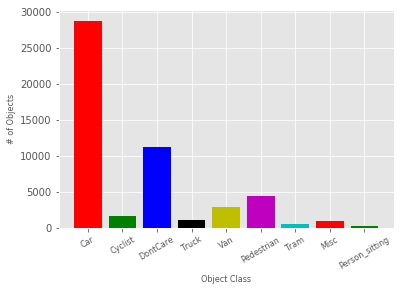

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

index = np.arange(len(object_dict))
my_colors = 'rgbkymc'
plt.bar(index, object_dict.values(), color=my_colors)
plt.xlabel('Object Class', fontsize=8)
plt.ylabel('# of Objects', fontsize=8)
plt.xticks(index, object_dict.keys(), fontsize=8, rotation=30)
plt.show()

Our first take-away is that, as expected, the dataset is heavily car-focused. In fact, ignoring the `DontCare` class (which the KITTI `readme.txt` explains as regions where getting a quality label does not make sense), a car is:

In [4]:
object_dict['Car'] / (sum(object_dict.values()) - object_dict['Car'] - object_dict['DontCare'])

2.4299966181941155

nearly 2.5 times more common than all other objects combined, and 

In [5]:
object_dict['Car'] / object_dict['Pedestrian']

6.405616224648986

more than 6 times as likely as the next most common object, a pedestrian.

Let's collect some more statistics now before visualizing what the labels represent. Specifically, let's now build some histograms to show how prevalent objects are in each image. That is, how many cars, pedestrians, vans, etc. show up in images on average.

In [6]:
from collections import defaultdict

per_image = {}
classes = ['Car', 'Cyclist', 'Pedestrian']

# list per class on number of objects per image
for c in classes:
    per_image[c] = []

# gather statistics
for label_file in os.listdir(label_dir):
    objects = defaultdict(int)
    for line in open(os.path.join(label_dir, label_file)):
        cols = line.split(' ')
        object_type = cols[0]
        objects[object_type] += 1
    for c in classes:
        per_image[c].append(objects[c])

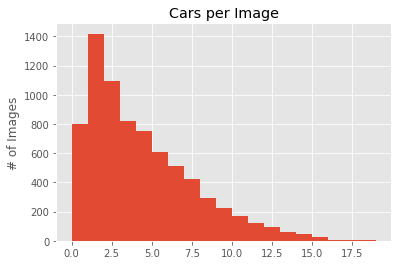

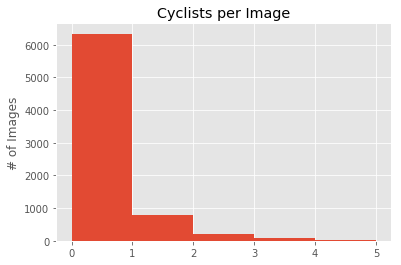

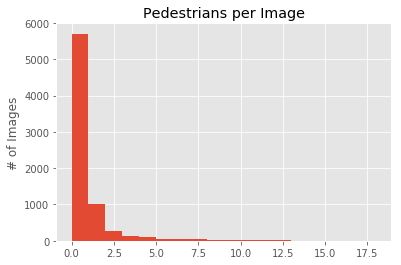

In [7]:
def stats_and_visualize(class_name):
    max_num = max(per_image[class_name])
    min_num = min(per_image[class_name])
    
    plt.hist(per_image[class_name], bins=np.arange(0, max_num+1, 1))
    plt.title("%ss per Image" % class_name)
    plt.ylabel("# of Images")
    plt.show()
    
stats_and_visualize('Car')
stats_and_visualize('Cyclist')
stats_and_visualize('Pedestrian')

Again it's clear that other cars are the most important object. The distributions of object types per image seem to follow a power distribution and in most cases there are only 0 or 1 of an object type in a given picture (though in the case of cars one car in an image is by far the most common).

We've discussed and calculated the contents of these images from the viewpoint of the labels that have been provided for them. But what do the images look like? Here are some random samples:

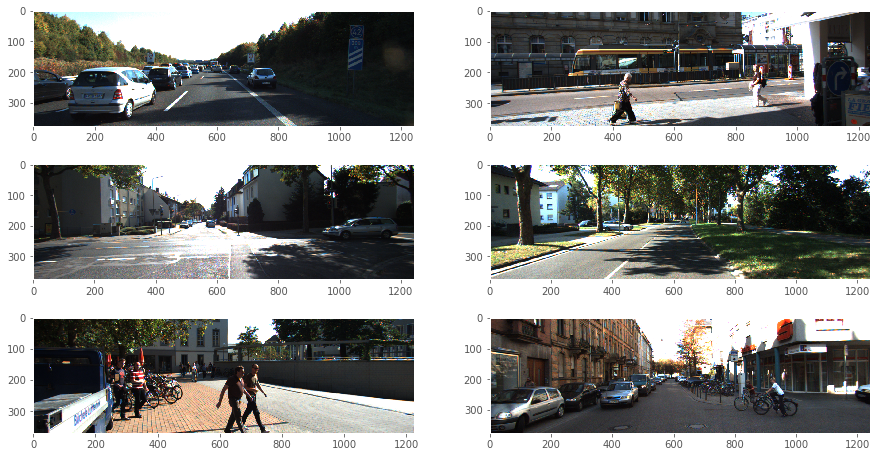

In [8]:
f, axarr = plt.subplots(3, 2, figsize=(15, 8))
curr_row = 0

image_ids = ['005431', '005432', '005433', '005434', '005435', '005436']
index = 0

for image_id in image_ids:
    image_path = 'data/full_training/image_2/' + image_id + '.png'
    a = plt.imread(image_path)

    col = index % 3
    axarr[col, curr_row].imshow(a)
    axarr[col, curr_row].grid(False)
    if col == 2:
        curr_row += 1
    index += 1
    
plt.show()

Let's quickly do some manual confirmation that the labels align with the images. For example, the image in the top right (`005434`) clearly contains a tram and two pedestrians. Here is the label file:

In [9]:
open('data/full_training/label_2/005434.txt').readlines()

['Tram 0.00 1 -0.22 237.19 95.75 718.62 252.21 3.71 2.80 13.02 -3.06 1.61 20.69 -0.37\n',
 'Tram 0.00 2 -0.56 678.83 107.46 809.72 222.12 3.48 2.75 3.22 4.63 1.22 23.64 -0.37\n',
 'Tram 0.00 2 -0.72 758.90 108.94 966.42 224.27 3.68 2.81 6.69 9.24 1.33 25.46 -0.38\n',
 'Pedestrian 0.00 2 2.50 1075.09 136.19 1176.75 295.78 1.82 0.94 1.09 6.33 1.31 8.73 3.11\n',
 'Pedestrian 0.00 0 2.93 837.34 165.97 916.01 318.95 1.64 0.80 0.99 2.97 1.48 8.18 -3.02\n',
 'Pedestrian 0.08 0 0.04 385.70 194.87 490.37 373.00 1.48 0.92 0.92 -1.48 1.61 6.12 -0.20\n']

Hmm... perhaps it was not so clear after all. For one, the label file lists 3 pedestrians but we only noticed 2. Remember that the 3 column lists the occlussion level (0 = fully visible, 1 = partly occluded, 2 = largely occluded, 3 = unknown) and one of the pedestrians has a 2 so is largely occluded. To figure out where this pedestrian is, and because we'll need to eventually for performing object detection, let's project the 3d bounding box labels on to the images and try to find the "mystery pedestrian".

In [10]:
import cv2

object_types = {
    'Car': (255, 0, 0),
    'Pedestrian': (0, 255, 0),
    'Cyclist': (0, 0, 255),
    'Tram': (255, 0, 255),
    'Van': (0, 255, 255)
}

def show_image_with_3d_objects(image_id):

    # open image
    image_path = 'data/full_training/image_2/' + image_id + '.png'
    image = cv2.imread(image_path)

    # read calibration data
    calib_file = 'data/full_training/calib/' + image_id + '.txt'
    for line in open(calib_file):
        # P2 is for the left color camera -- which is what we use
        if 'P2:' in line:
            cam_to_img = line.strip().split(' ')
            cam_to_img = np.asarray([float(number) for number in cam_to_img[1:]])
            cam_to_img = np.reshape(cam_to_img, (3,4))

    label_path = 'data/full_training/label_2/' + image_id + '.txt'

    for line in open(label_path).readlines():
        cols = line.strip().split(' ')
        object_type = cols[0]
    
        if object_type in object_types:
            # Draw 2D Bounding Box
            x_min, y_min, x_max, y_max = [int(float(number)) for number in cols[4:8]]

            # Draw 3D Bounding Box
            dims   = np.asarray([float(number) for number in cols[8:11]])
            center = np.asarray([float(number) for number in cols[11:14]])
        
            # if the observation angle is too small then don't bother trying to visualize it
            if np.abs(float(cols[3])) < 0.01:
                continue
        
            rot_y  = float(cols[3]) + np.arctan(center[0] / center[2])        
            box_3d = []

            for i in [1,-1]:
                for j in [1,-1]:
                    for k in [0,1]:
                        point = np.copy(center)
                        point[0] = center[0] + i * dims[1]/2 * np.cos(-rot_y+np.pi/2) + (j*i) * dims[2]/2 * np.cos(-rot_y)
                        point[2] = center[2] + i * dims[1]/2 * np.sin(-rot_y+np.pi/2) + (j*i) * dims[2]/2 * np.sin(-rot_y)                  
                        point[1] = center[1] - k * dims[0]

                        point = np.append(point, 1)
                        point = np.dot(cam_to_img, point)
                        point = point[:2]/point[2]
                        point = point.astype(np.int16)
                        box_3d.append(point)

            for i in range(4):
                point_1_ = box_3d[2*i]
                point_2_ = box_3d[2*i+1]
                cv2.line(image, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), object_types[object_type], 3)
            
            for i in range(8):
                point_1_ = box_3d[i]
                point_2_ = box_3d[(i+2)%8]
                cv2.line(image, (point_1_[0], point_1_[1]), (point_2_[0], point_2_[1]), object_types[object_type], 3)
            
    fig = plt.figure(figsize=(20,20))
    
    # remember that cv2 stores RGB information in the opposite order as matplotlib...
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.grid(False)
    plt.show()

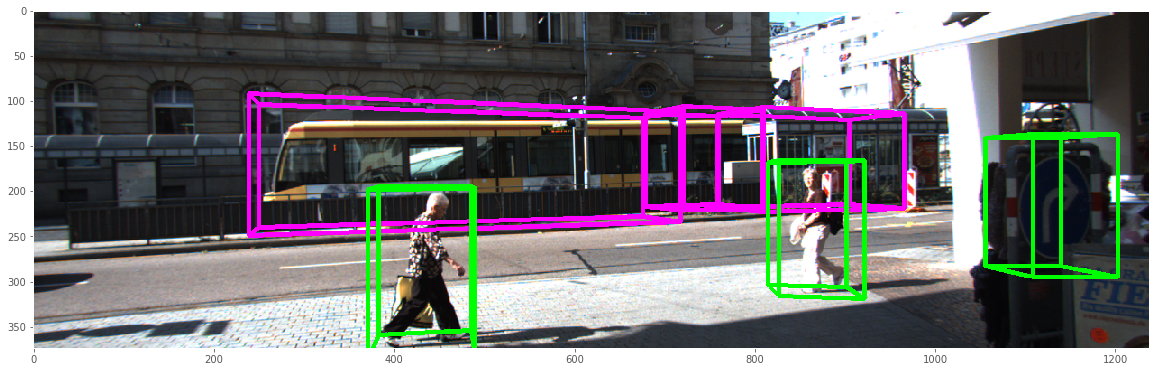

In [11]:
show_image_with_3d_objects('005434')

The above visualization immediately clears up the three `Tram` instances: they were simply split apart. We have also found the mystery pedestrian though to be honest I still don't see him or her. Let's look at one more label file, image, and projection visualization. The image on the bottom-right (`005436`) contains a couple of cyclists, several cars, and a pedestrian. Let's look at the label file first:

In [12]:
open('data/full_training/label_2/005436.txt').readlines()

['Car 0.42 0 2.14 0.00 213.22 249.50 374.00 1.45 1.52 3.62 -5.75 2.00 8.15 1.54\n',
 'Car 0.00 0 1.78 349.39 200.34 489.72 302.32 1.46 1.62 4.04 -3.35 2.03 13.28 1.54\n',
 'Car 0.00 1 1.97 166.03 203.68 358.57 313.12 1.46 1.58 3.72 -5.77 2.06 12.39 1.55\n',
 'Cyclist 0.00 1 2.97 791.31 188.80 929.57 305.18 1.55 0.57 1.73 3.41 1.79 10.07 -3.00\n',
 'Car 0.83 0 2.40 1176.91 164.25 1241.00 277.93 1.73 1.55 4.00 11.56 1.58 11.38 -3.10\n',
 'Cyclist 0.00 0 -3.12 852.93 187.50 1010.55 328.96 1.55 0.69 1.63 3.76 1.73 8.60 -2.72\n',
 'Pedestrian 0.00 1 2.14 112.45 188.09 147.12 296.27 1.84 0.57 0.28 -8.35 2.10 12.45 1.56\n',
 'Car 0.00 2 1.67 491.11 192.18 544.68 239.49 1.57 1.60 3.99 -3.43 2.33 27.14 1.54\n',
 'Car 0.00 1 1.63 534.22 191.31 562.98 218.00 1.52 1.54 3.68 -3.81 2.71 44.90 1.55\n',
 'Van 0.00 1 1.61 547.12 181.19 571.28 209.48 2.47 1.98 5.81 -4.65 3.25 66.60 1.54\n',
 'Car 0.00 1 -0.12 634.73 185.37 731.24 223.65 1.62 1.65 4.14 3.21 2.22 32.55 -0.03\n',
 'Car 0.00 1 0.01 612.36 1

It looks good (with a couple of vans in there as well; later we will see that the actual 3D Object Detection competition only considers `Car`s and `Pedestrian`s). Here is the visualization:

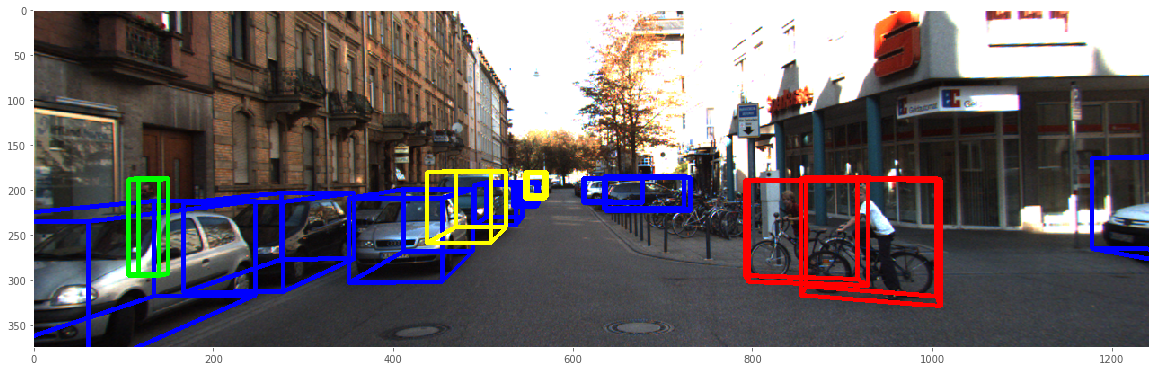

In [13]:
show_image_with_3d_objects('005436')

Perfect! One last thing before continuing to other aspects of the dataset is a fundamental issue: the aspect ratio and actual sizes of the images. They are clearly very wide compared to an image taken with a typical mobile phone, for example.

In [14]:
image_path = 'data/full_training/image_2/' + image_ids[0] + '.png'
image = cv2.imread(image_path)

image.shape

(376, 1241, 3)

The images are `[1241 x 376]` and, naturally, contain 3 color channels. This gives an aspect ratio of 3.3:1, or almost twice as wide as standard 16:9 HD Video. Let's now finally move on to the last source of data that we will consider.

The final source of data is the corresponding Velodyne Point Clouds. The Velodyne data is stored as binary files in the format of `[x, y, z, reflectance]` for each scan. From [2], "[e]ach point is stored with its (x, y, z) coordinate and an additional reflectance value (r). While the number of points per scan is not constant, on average each file/frame has a size of ∼ 1.9 MB which corresponds to ∼ 120, 000 3D points and reflectance values." Let's take a look at the data for a single frame: 

In [16]:
# take a look at some velodyne data

velo_datafile = 'data/full_training/velodyne/' + '005434' + '.bin'

velo = np.fromfile(velo_datafile, dtype=np.float32)
velo = velo.reshape((-1, 4))

print(velo.shape)
print(velo)

print(np.mean(velo[:,3]))

(123902, 4)
[[18.414  0.02   0.832  0.36 ]
 [18.392  0.078  0.831  0.22 ]
 [18.367  0.135  0.83   0.   ]
 ...
 [ 3.707 -1.389 -1.73   0.   ]
 [ 3.716 -1.379 -1.732  0.   ]
 [ 7.817 -2.572 -3.721  0.   ]]
0.25658315


As promised, there are about 120,000 3D points (closer to 124k for this particular frame) along with their reflectance values. The average reflectance value (in this particular scan) is about 0.25. More interestingly, let's plot the points for this particular frame.

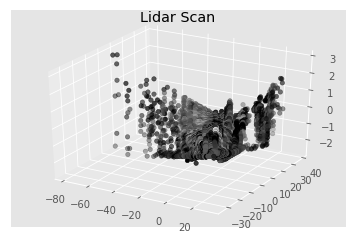

In [17]:
from mpl_toolkits.mplot3d import Axes3D

skip = 10 # plot one in every `skip` points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
velo_range = range(0, velo.shape[0], skip) # skip points to prevent crash
ax.scatter(velo[velo_range, 0],   # x
           velo[velo_range, 1],   # y
           velo[velo_range, 2],   # z
           c=velo[velo_range, 3], # reflectance
           cmap='gray')
ax.set_title('Lidar Scan')
plt.show()

The above shows us *something* about the point cloud data given by the LIDAR -- and stand-alone images and related point-clouds are what the state-of-the-art 3d object detection methods use -- but it does not give us a very good "feel" for either the data or how it was collected. To get a better understanding of it, we should stitch several frames together and animate them. Let's try it out.

### Better visualization of Velodyne data

The first problem we face is that the KITTI dataset samples (images, labels, velodyne scans) have been randomized. 

In [36]:
from matplotlib import rc
import matplotlib.animation as animation
from IPython.display import HTML
rc('animation', html='html5')

location = 'data/full_training/image_2/'
names = ['000000.png', '000001.png', '000002.png', '000003.png', '000004.png', '000005.png', '000006.png', '000007.png', '000008.png', '000009.png']
filenames = [os.path.join(location, img) for img in names]
ims = []

fig = plt.figure(figsize=(10,6))
plt.grid(False)

for i in range(len(imgs)):
    im = plt.imshow(plt.imread(filenames[i]), animated=True)
    ims.append([im])

anim = animation.ArtistAnimation(fig, ims, interval=500, blit=False, repeat=True)
plt.close()
HTML(anim.to_html5_video())

As the video above shows, putting numerically contiguous images together does not result in a true video, rather, we see a collection of random video frames. However, the KITTI [object development kit](https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip) contains mapping files that map all of the training data files to the date and time where they were collected. `train_rand.txt` assigns a unique index to each image from the training set, and `train_mapping.txt` maps each of the random indices to the KITTI raw data set files. We can use this information to find contiguous frames, go backwards to the corresponding images and LIDAR scans, and create data visualizations to help us understand how the LIDAR data looks and behaves.

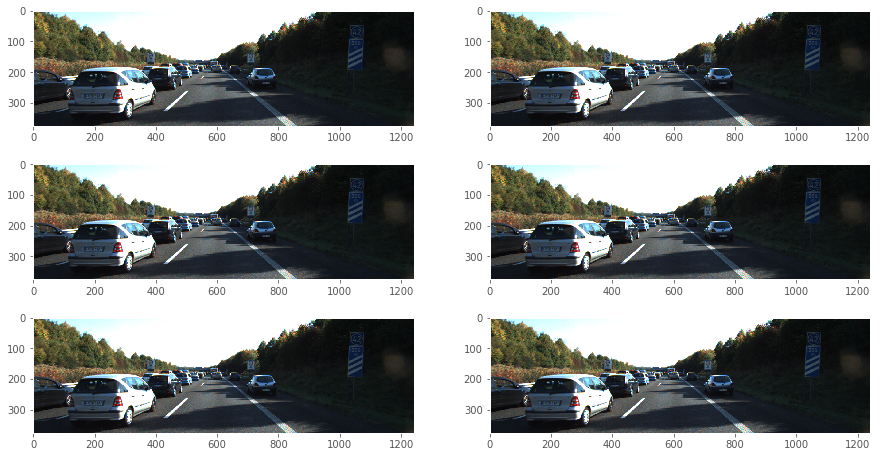

In [55]:
# load the maps to be able to find time-contiguous data samples...

# the indices are 1-based
indices = [int(i) - 1 for i in open('data/train_rand.txt').read().strip().split(',')]

# line number from train_mapping.txt to image number in training set
index_map = {indices[i]:i for i in range(len(indices))}

# get contiguous files to random indices
file_data = [a.strip() for a in open('data/train_mapping.txt').readlines()]
file_to_index = {file_data[i]:index_map[i] for i in range(len(file_data))}

# let's look at the first several to see if they line up
f, axarr = plt.subplots(3, 2, figsize=(15, 8))
curr_row = 0

i = 0
for k in file_to_index.keys():
    filename = 'data/full_training/image_2/' + "{:06}".format(file_to_index[k]) + ".png"
    a = plt.imread(image_path)
    
    col = i % 3
    axarr[col, curr_row].imshow(a)
    axarr[col, curr_row].grid(False)
    if col == 2:
        curr_row += 1
    
    i += 1
    if i == 6:
        break
    
plt.show()

It looks like it worked! To be 100% sure, and to find a suitable range to visualize for the LIDAR data, let's find a large selection of contiguous frames and make a quick animation to be sure that it behaves like actual video. Because others have used one particular drive -- the `2011_09_26_drive_0001_sync` -- we will narrow down the data required for that drive and visualize it.

In [ ]:
# load up the 2011_09_26_drive_0001_sync
# make a video of the images
# then make a couple of videos (following the navoshta -- AND CITE HIM -- code) of the LIDAR data
# then finally move to the actual object detection.

In [63]:
# find the IDs for all of the frames in 2011_09_26_drive_0001_sync
ids = [file_to_index[i] for i in file_to_index if '2011_09_26_drive_0001' in i]
print(len(ids))

# make a video of the images
filenames = ['data/full_training/image_2/' + "{:06}".format(id) + ".png" for id in ids]
ims = []

fig = plt.figure(figsize=(10,6))
plt.grid(False)

for i in range(len(imgs)):
    im = plt.imshow(plt.imread(filenames[i]), animated=True)
    ims.append([im])

anim = animation.ArtistAnimation(fig, ims, interval=100, blit=False, repeat=True)
plt.close()
HTML(anim.to_html5_video())

51


Success! Now let's look at the LIDAR data for this short snippet of time. However, as mentioned above, this is a common section of the dataset in the literature (and online) and to simplify things, we will borrow some code from [Alex Staravoitau](https://github.com/navoshta/KITTI-Dataset) to help visualize the LIDAR data. Further, we will use the full sync from 2011_09_26_drive_0001 which is available from the KITTI website [here](http://kitti.is.tue.mpg.de/kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip). This includes an additional 50 or so frames and the tracklet (label) information in an XML format:

In [75]:
print(open('data/2011_09_26/2011_09_26_drive_0001_sync/tracklet_labels.xml').read()[:500])
print('...')

<?xml version="1.0" encoding="UTF-8" standalone="yes" ?>
<!DOCTYPE boost_serialization>
<boost_serialization signature="serialization::archive" version="9">
<tracklets class_id="0" tracking_level="0" version="0">
	<count>15</count>
	<item_version>1</item_version>
	<item class_id="1" tracking_level="0" version="1">
		<objectType>Car</objectType>
		<h>2.1672349</h>
		<w>1.7057118</w>
		<l>4.3293562</l>
		<first_frame>0</first_frame>
		<poses class_id="2" tracking_level="0" version="0">
			<count>1
...


We will also make use of the `pykitti` python module which provides some convenience methods for dealing with KITTI data. Let's start by loading up the full information in the dataset for this particular drive data.

In [76]:
import pykitti

basedir = 'data'

# Specify the dataset to load
date = '2011_09_26'
drive = '0001'

def load_dataset(date, drive, calibrated=False, frame_range=None):
    dataset = pykitti.raw(basedir, date, drive)

    # Load the data
    if calibrated:
        dataset.load_calib()  # Calibration data are accessible as named tuples

    np.set_printoptions(precision=4, suppress=True)
    print('\nDrive: ' + str(dataset.drive))
    print('\nFrame range: ' + str(dataset.frames))

    if calibrated:
        print('\nIMU-to-Velodyne transformation:\n' + str(dataset.calib.T_velo_imu))
        print('\nGray stereo pair baseline [m]: ' + str(dataset.calib.b_gray))
        print('\nRGB stereo pair baseline [m]: ' + str(dataset.calib.b_rgb))

    return dataset

In [77]:
dataset = load_dataset(date, drive)


Drive: 2011_09_26_drive_0001_sync

Frame range: None


We will now use a method from Alex to load up the trackletsthat we will use to visualize the labels on our LIDAR data.

In [78]:
import parseTrackletXML as xmlParser

def load_tracklets_for_frames(n_frames, xml_path):
    tracklets = xmlParser.parseXML(xml_path)

    frame_tracklets = {}
    frame_tracklets_types = {}
    for i in range(n_frames):
        frame_tracklets[i] = []
        frame_tracklets_types[i] = []

    # loop over tracklets
    for i, tracklet in enumerate(tracklets):
        h, w, l = tracklet.size

        # in velodyne coordinates around zero point and without orientation yet
        trackletBox = np.array([
            [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
            [0.0, 0.0, 0.0, 0.0, h, h, h, h]
        ])
        
        # loop over all data in tracklet
        for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in tracklet:
            # determine if object is in the image; otherwise continue
            if truncation not in (xmlParser.TRUNC_IN_IMAGE, xmlParser.TRUNC_TRUNCATED):
                continue
            
            # re-create 3D bounding box in velodyne coordinate system
            yaw = rotation[2]  # other rotations are supposedly 0
            assert np.abs(rotation[:2]).sum() == 0, 'object rotations other than yaw given!'
            rotMat = np.array([
                [np.cos(yaw), -np.sin(yaw), 0.0],
                [np.sin(yaw), np.cos(yaw), 0.0],
                [0.0, 0.0, 1.0]
            ])
            cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8, 1)).T
            frame_tracklets[absoluteFrameNumber] = frame_tracklets[absoluteFrameNumber] + [cornerPosInVelo]
            frame_tracklets_types[absoluteFrameNumber] = frame_tracklets_types[absoluteFrameNumber] + [
                tracklet.objectType]

    return (frame_tracklets, frame_tracklets_types)

In [80]:
tracklet_rects, tracklet_types = load_tracklets_for_frames(len(list(dataset.velo)), \
                                                           'data/{}/{}_drive_{}_sync/tracklet_labels.xml'.format(date, date, drive))

Parsing tracklet file data/2011_09_26/2011_09_26_drive_0001_sync/tracklet_labels.xml
File contains 15 tracklets
Loaded 15 tracklets.


We have the tracklets, we have the images, and we have the point cloud data. Now it's time to visualize it.

In [111]:
colors = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k'
}
axes_limits = [
    [-20, 80], # X axis range
    [-20, 20], # Y axis range
    [-3, 10]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]   # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

def show_image_and_velodyne(dataset, tracklet_rects, tracklet_types, frame, points=0.3):
    dataset_rgb = list(dataset.rgb)
    dataset_velo = list(dataset.velo)
    
    print('Frame timestamp: ' + str(dataset.timestamps[frame]))
    # Draw camera data -- just show the left image (cam2)
    f, ax = plt.subplots(figsize=(15, 5))
    ax.imshow(dataset_rgb[frame][0])
    ax.set_title('RGB Image (cam2)')
    ax.grid(False)
    plt.show()

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]      
    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=velo_frame[:, 3], cmap='gray')
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
            
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
            
        for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
            draw_box(ax, t_rects, axes=axes, color=colors[t_type])
            
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(15, 8))
    ax2 = f2.add_subplot(111, projection='3d')                    
    draw_point_cloud(ax2, 'Velodyne scan', xlim3d=(-10,30))
    plt.show()
    
    # Draw point cloud data as plane projections
    f, ax3 = plt.subplots(1, 1, figsize=(15, 5))
    draw_point_cloud(
        ax3, 
        'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right', 
        axes=[0, 1] # X and Y axes
    )
    plt.show()

Frame timestamp: 2011-09-26 13:02:29.064558


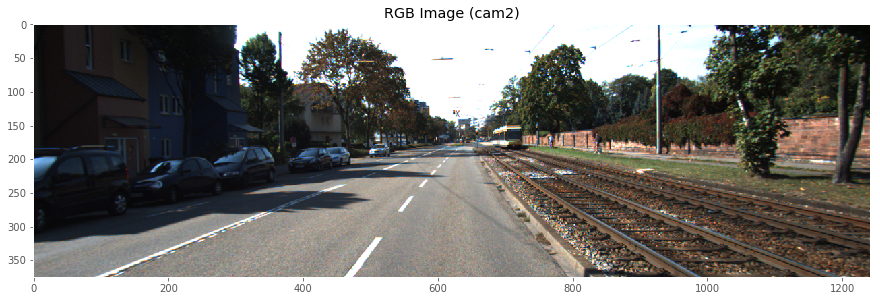

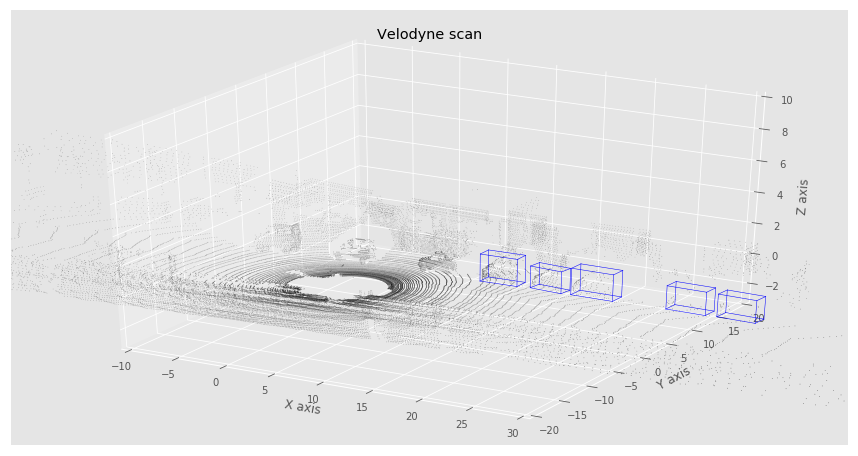

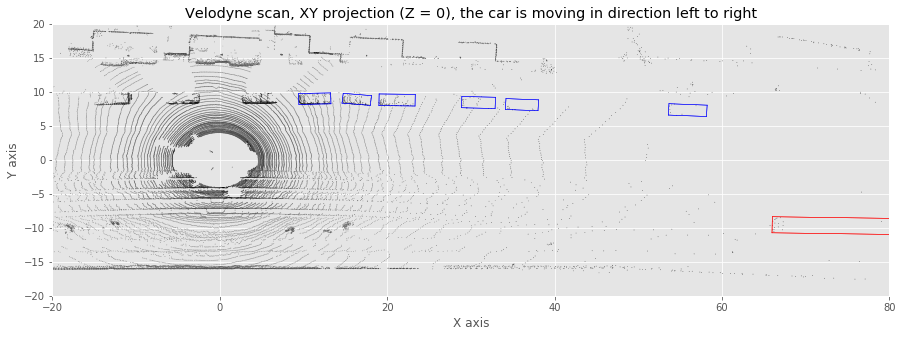

In [113]:
frame = 30
show_image_and_velodyne(dataset, tracklet_rects, tracklet_types, frame)

There are three images above representing frame `30` in the sync. The first shows the image from the RGB (left) camera and is of course the most interpretable for humans. The second and third, however, show the Velodyne scan data and the tracklets for the cars (blue) and the tram (red). We first show a 3d plot and then a projection from a "birds-eye" view. Both clearly show where the car is and how the laser radially emanates from the car. The 3d plot shows some fairly clear 3d representations of the cars just to the viewpoint-car's left and both show how difficult (at least for humans) it is to translate LIDAR data to particular object types.

Finally, then, we will animate the frames' LIDAR data to see how it looks dynamically (we again use make use of Alex's code to do achieve this).

In [116]:
from utilities import print_progress
from moviepy.editor import ImageSequenceClip

def draw_3d_plot(frame, dataset, tracklet_rects, tracklet_types, points=0.2):
    dataset_velo = list(dataset.velo)
    
    f = plt.figure(figsize=(12, 8))
    axis = f.add_subplot(111, projection='3d', xticks=[], yticks=[], zticks=[])

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]
    axis.scatter(*np.transpose(velo_frame[:, [0, 1, 2]]), s=point_size, c=velo_frame[:, 3], cmap='gray')
    axis.set_xlim3d(*axes_limits[0])
    axis.set_ylim3d(*axes_limits[1])
    axis.set_zlim3d(*axes_limits[2])
    for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
        draw_box(axis, t_rects, axes=[0, 1, 2], color=colors[t_type])
    filename = 'video/frame_{0:0>4}.png'.format(frame)
    plt.savefig(filename)
    plt.close(f)
    return filename

frames = []
n_frames = len(list(dataset.velo))

print('Preparing animation frames...')
for i in range(n_frames):
    print_progress(i, n_frames - 1)
    filename = draw_3d_plot(i, dataset, tracklet_rects, tracklet_types)
    frames += [filename]
print('...Animation frames ready.')

clip = ImageSequenceClip(frames, fps=5)
clip.write_gif('pcl_data.gif', fps=5)

Preparing animation frames...
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
...Animation frames ready.

[MoviePy] Building file pcl_data.gif with imageio


100%|██████████| 108/108 [00:08<00:00, 13.37it/s]


![video](pcl_data.gif "video")

### 3D Object Detection Benchmark

Great! Now that we understand the data a lot better, we can finally take a look at the specific task: 3D object detection. From the `readme.txt` for this challenge:

>The goal in the 3D object detection task is to train object detectors for the classes 'Car', 'Pedestrian', and 'Cyclist'. The object detectors must provide BOTH the 2D 0-based bounding box in the image as well as the 3D bounding box (in the format specified above, i.e. 3D dimensions and 3D locations) and the detection score/confidence. Note that the 2D bounding box should correspond to the projection of the 3D bounding box - this is required to filter objects larger than 25 pixel (height). [...]



### Future Work

The KITTI 3D Object benchmark and the associated KITTI dataset represent an enormous source of information of the world that a self-driving car would find itself immersed in. ...

- Combining image data with velodyne data
- Using sequence / continuity information to introduce constraints of where objects could possible be found
- ...


## References

1. Geiger, Andreas, Philip Lenz, and Raquel Urtasun. "Are we ready for autonomous driving? the kitti vision benchmark suite." *Computer Vision and Pattern Recognition (CVPR)*, 2012 IEEE Conference on. IEEE, 2012.

2. Geiger, Andreas, et al. "Vision meets robotics: The KITTI dataset." *The International Journal of Robotics Research 32.11* (2013): 1231-1237.